### <b> Import Libs </b>

In [33]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import jax
import pandas as pd
import netket.nn as nknn
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import math 
import time

### <b> Initialize Variables </b>

In [34]:
N_iter = 300; i = 75; L = 12
rad = math.radians(i); sin = math.sin(rad); cos = math.cos(rad)
j1  = sin
j2  = cos
J     = [j1,j2]

### <b> Define Internal Functions </b>

In [35]:
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x

# Define a função de perda (loss function) para o treinamento
def loss(params, structure_factor):
    output = model.apply({'params': params}, structure_factor)
    return jnp.mean(output)
# Função de callback para salvar os parâmetros durante o treinamento
def save_params(step, params, energy):
    trained_params_list.append(params.copy())
    parameters_list.append(energy.state.parameters.copy())
    iii.append(1)
    return True

def info(e):
    head   = list(e.keys())[0]
    body   = list(e[head].keys())
    bias   = e[head][body[0]]
    kernel = e[head][body[1]]
    return  head, body, list(bias), list(kernel)
def real(c):
    return float(np.real(c))  
def img(c):
    return float(np.imag(c))    
def r_i(c):
    return real(c),img(c)  

### <b> Run App</b>

In [36]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])
# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)

model = FFNN()

vs = nk.vqs.MCState(sa, model, n_samples=1008)
opt = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.01)
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

In [37]:
vs_i_parameters = vs.parameters.copy()

In [38]:
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L

# Define uma lista para armazenar os parâmetros do modelo durante o treinamento
trained_params_list = []
parameters_list     = []
iii                 = []

In [39]:
gs.run(out='test', n_iter=N_iter, obs={'Structure Factor': structure_factor}, callback=save_params)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.07it/s, Energy=-18.6299+0.0014j ± 0.0074 [σ²=0.0557, R̂=1.0048]]


(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.1122579574584961
   	Params: 0.0012097358703613281,)

### <b> Results </b>

In [40]:
head, body, bias_list,kernel_list = info(parameters_list[-1])

In [41]:
real_df = pd.DataFrame()
img_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for bias in bias_list:
        nr, ni = r_i(bias); 
        real_v.append(nr)
        img_v.append(ni)   
    
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
        
    real_df = pd.concat([real_df,real_row_df])
    img_df  = pd.concat([img_df,img_row_df])   

In [ ]:
N_iter = 300; i = 75; L = 12
rad = math.radians(i); sin = math.sin(rad); cos = math.cos(rad)
j1  = sin
j2  = cos
J   = [j1,j2]

In [45]:
path_nm = "data/" + str(i) + "_" + str(L)  + "_"  + str(N_iter)
real_df.to_csv(path_nm + "_bias_real.csv",index=None) 
img_df.to_csv(path_nm + "_bias_img.csv",index=None) 

In [ ]:
real_df.shape

In [13]:
real_df.insert(0, 'id', range(1, 1 + len(real_df)))
img_df.insert(0, 'id', range(1, 1 + len(img_df)))

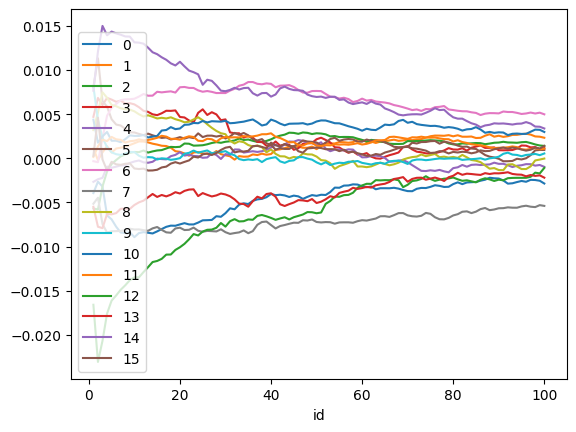

In [14]:
real_df.plot('id',y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

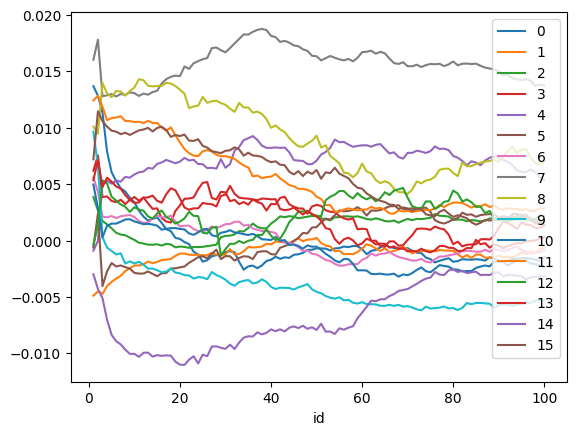

In [15]:
img_df.plot('id',y=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

In [46]:
real_kernel_df = pd.DataFrame()
img_kernel_df  = pd.DataFrame()
for param in parameters_list:
    head, body, bias_list,kernel_list = info(param)
    real_v = [];img_v = []
    for ks in kernel_list:
        for k in ks:
            nr, ni = r_i(k); 
            real_v.append(nr)
            img_v.append(ni) 
    real_row_df = pd.DataFrame([real_v])
    img_row_df  = pd.DataFrame([img_v])
    
    real_kernel_df = pd.concat([real_kernel_df,real_row_df])
    img_kernel_df  = pd.concat([img_kernel_df,img_row_df])  

In [47]:
real_kernel_df.insert(0, 'id', range(1, 1 + len(real_kernel_df)))
img_kernel_df.insert(0, 'id', range(1, 1 + len(img_kernel_df)))

In [48]:
path_nm = "data/" + str(i) + "_" + str(L)  + "_"  + str(N_iter)
real_kernel_df.to_csv(path_nm + "_kernel_real.csv",index=None) 
img_kernel_df.to_csv(path_nm + "_kernel_img.csv",index=None) 

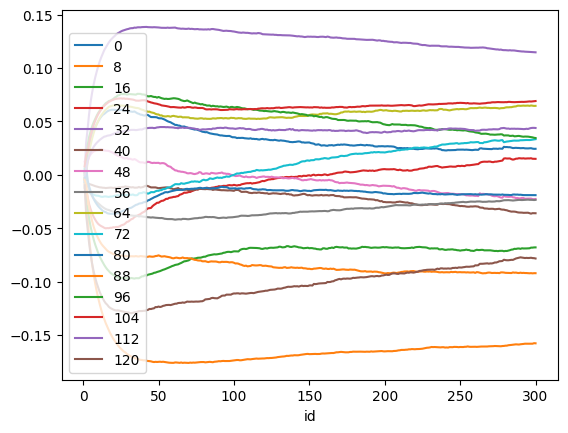

In [49]:
yt = []
for i in range(0,128): 
    if i % 8==0:
        yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()

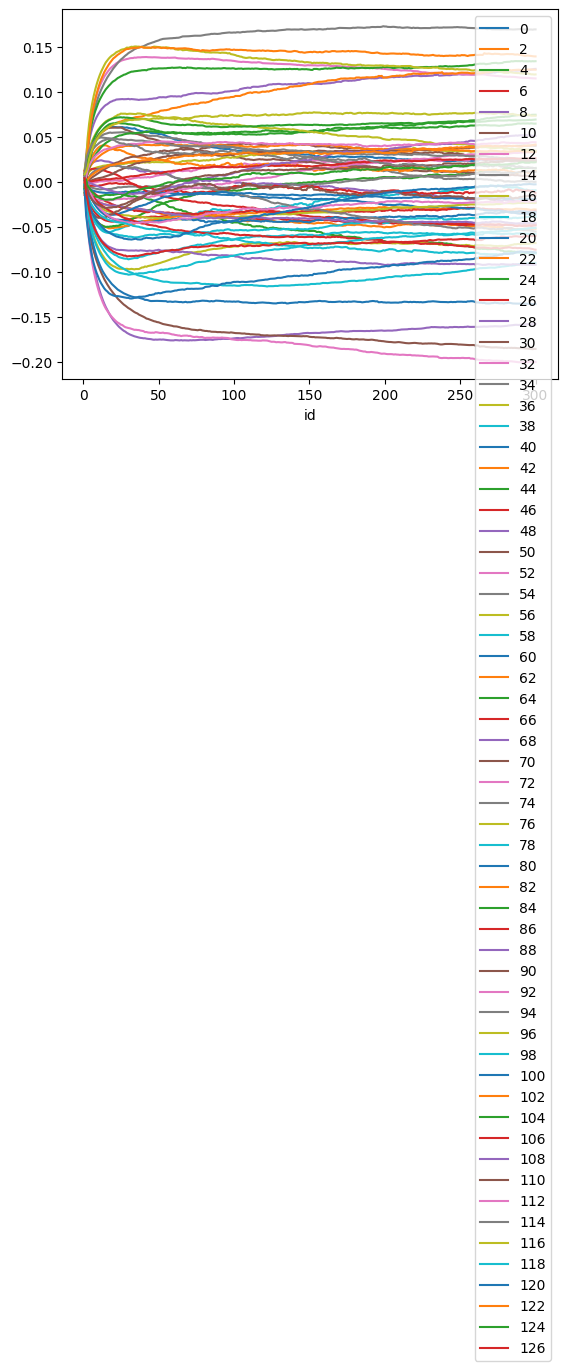

In [50]:
yt = []
for i in range(0,128): 
    if i % 2 ==0:
        yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()

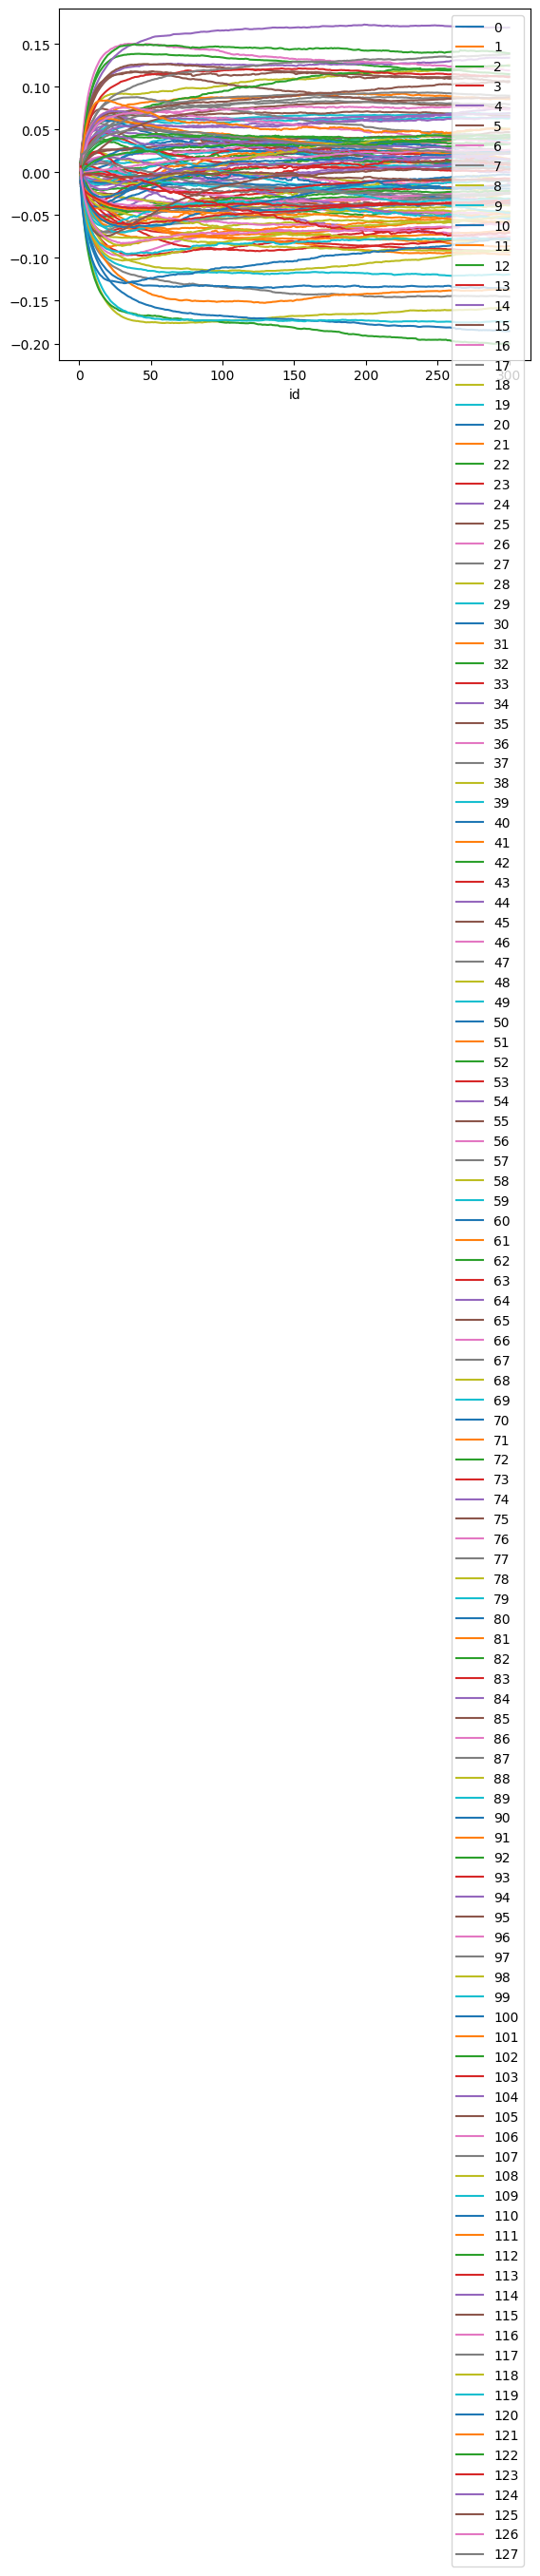

In [51]:
yt = []
for i in range(0,128): 
    yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()

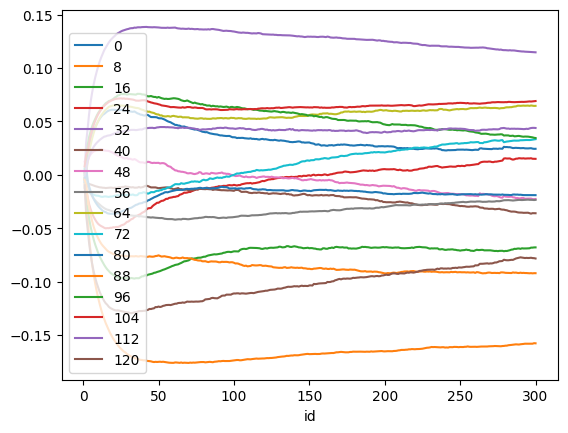

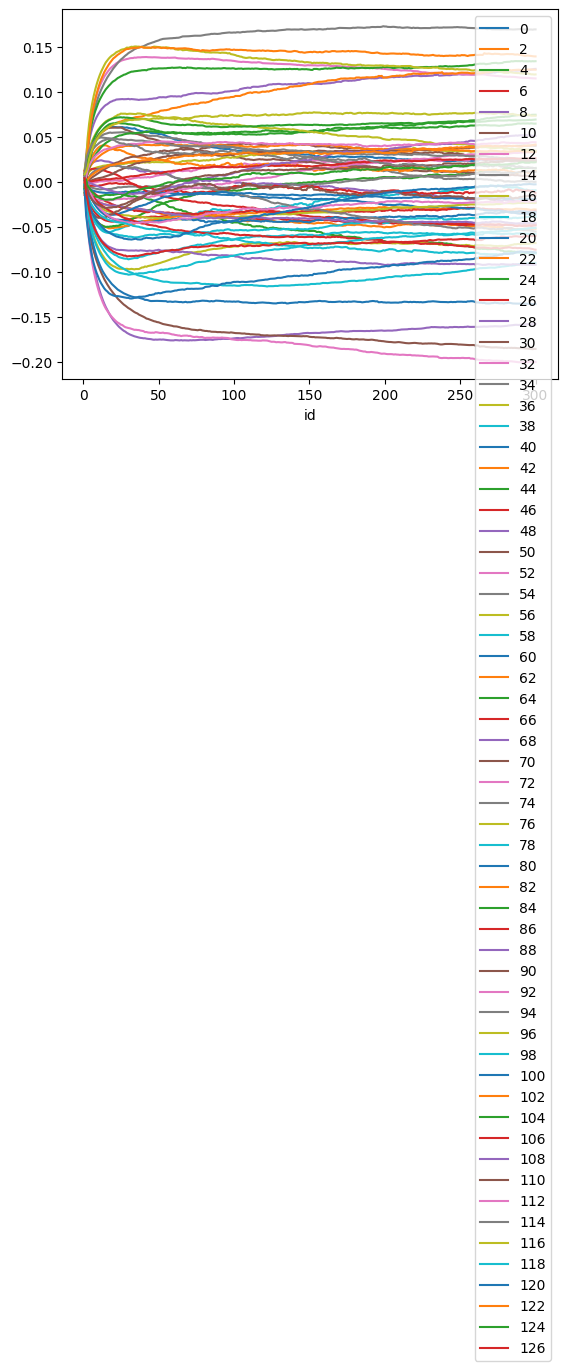

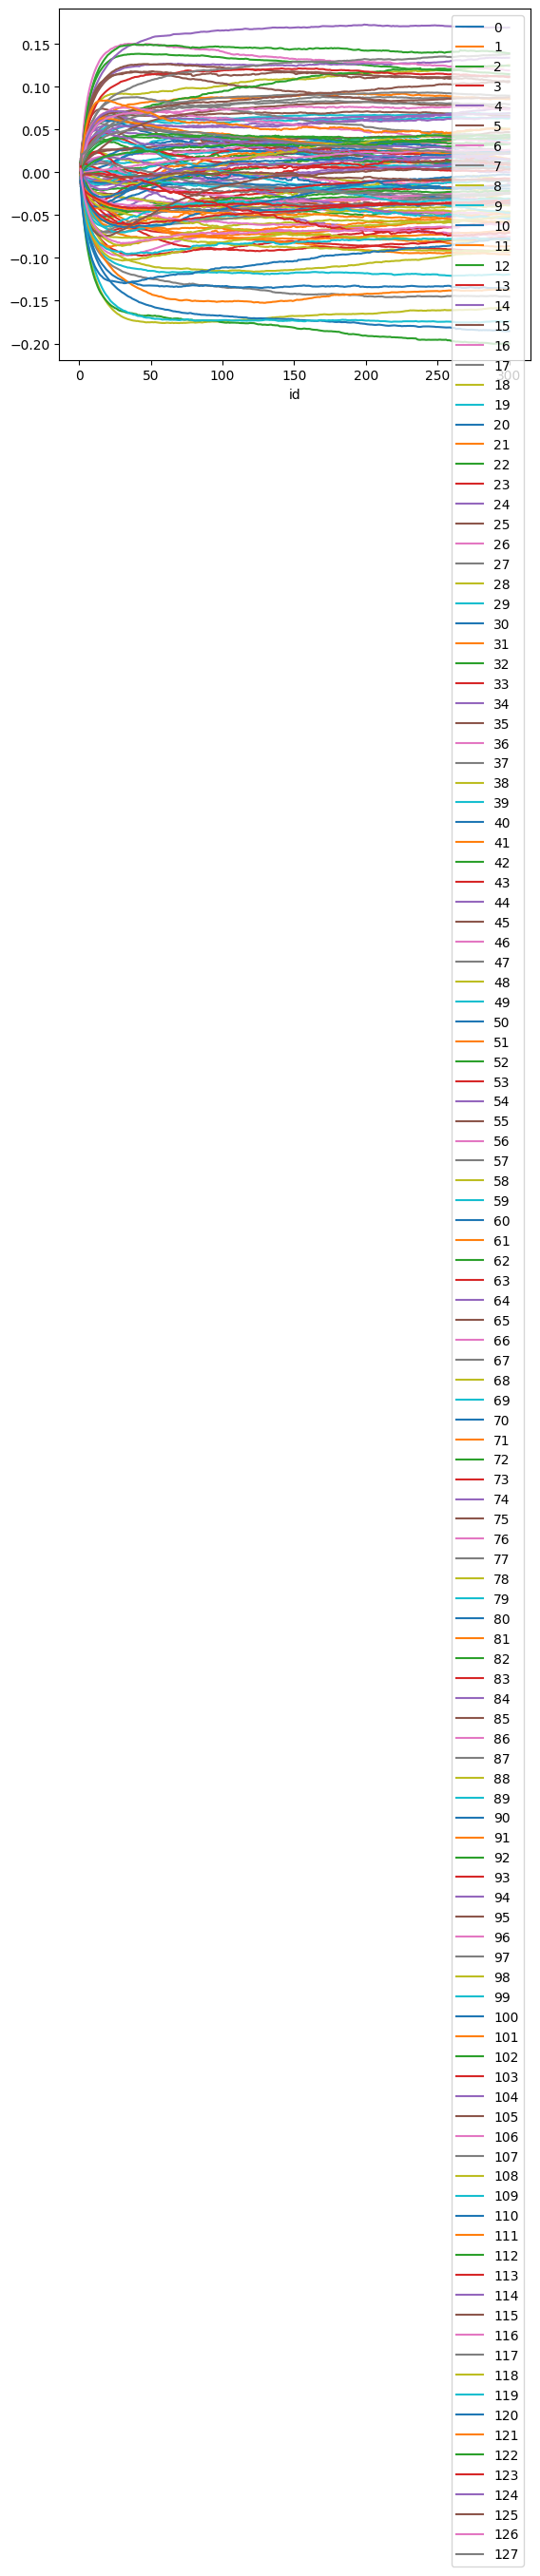

In [52]:
yt = []
for i in range(0,128): 
    if i % 8 ==0:
        yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()

yt = []
for i in range(0,128): 
    if i % 2 ==0:
        yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()

yt = []
for i in range(0,128): 
    yt.append(i)  
real_kernel_df.plot('id',y=yt)
plt.show()